# [트랜스포머 모델](https://github.com/crimsonjoo/Easy-Transformer/blob/main/Model/Transformer_Model.py)
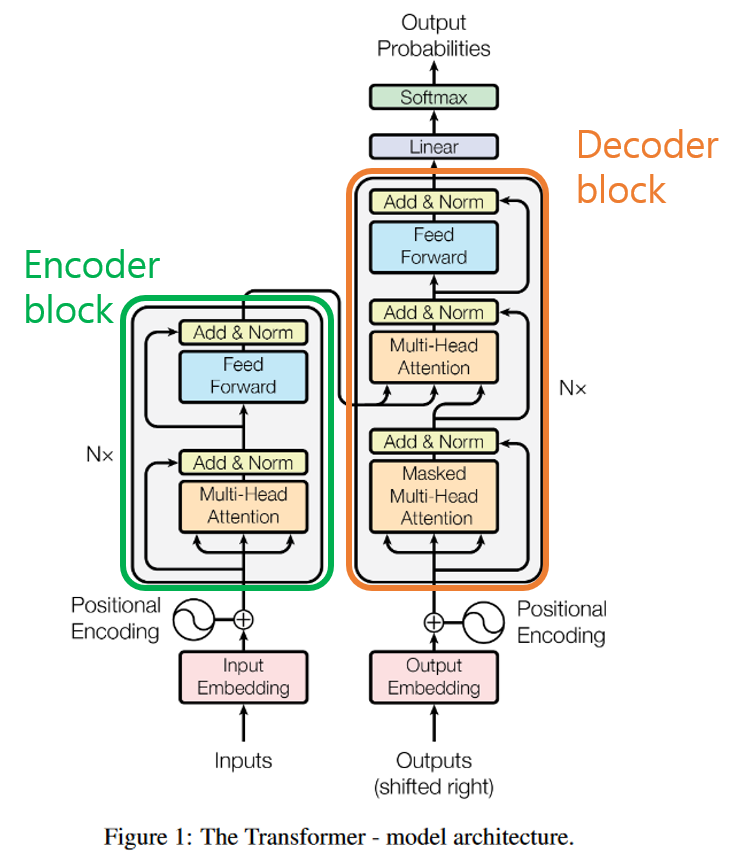


트랜스포머는 자연어 처리(NLP) 분야에서 주목받는 모델 중 하나입니다. "Attention is All You Need" 논문에서 처음 소개되었습니다. 이 모델은 기존의 순차적으로 정보를 처리하는 RNN(Recurrent Neural Networks)이나 LSTM(Long Short-Term Memory)과 달리 전체 입력 데이터를 한 번에 처리하는 어텐션 메커니즘을 사용합니다. 이를 통해 병렬 처리가 가능해져 학습 속도가 향상됩니다.

---

&nbsp;

# 트랜스포머 구성 요소

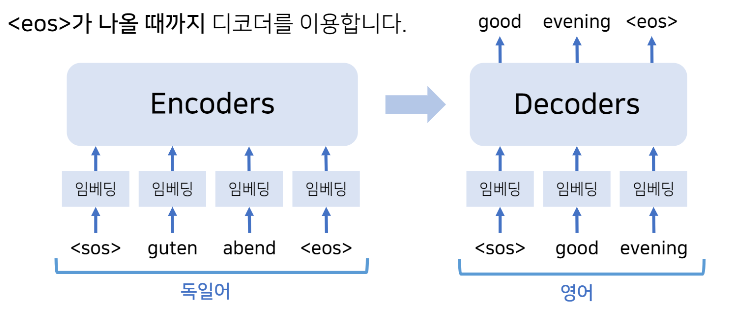

##인코더

1. **멀티헤드 어텐션(Multi-Head Attention):** 입력 데이터의 각 위치에서 다른 위치의 중요도를 평가하여 정보를 종합합니다. 멀티헤드 어텐션을 사용함으로써 다양한 표현 공간에서 정보를 추출할 수 있습니다.
2. **포지션 와이즈 피드포워드 네트워크(Position-wise Feed-Forward Networks):** 각 위치에서 독립적으로 동작하는 완전 연결 네트워크입니다. 각 위치의 정보에 비선형 변환을 적용합니다.
3. **레이어 노멀라이제이션과 드롭아웃(Layer Normalization and Dropout):** 모델의 학습을 안정화시키고 과적합을 방지합니다.


##디코더


1. **셀프 어텐션(Self-Attention) 및 멀티헤드 어텐션:** 디코더 내의 이전 위치에서 정보를 종합합니다. 인코더와 마찬가지로 멀티헤드 어텐션을 사용합니다.
2. **인코더-디코더 어텐션(Encoder-Decoder Attention):** 디코더가 인코더의 출력을 참조하여 입력 데이터와 관련된 출력을 생성할 수 있도록 합니다.
3. **포지션 와이즈 피드포워드 네트워크와 레이어 노멀라이제이션:** 인코더와 동일한 역할을 수행합니다.

디코더는 인코더와 비슷한 구조를 가지지만, 추가적으로 인코더-디코더 어텐션 층을 포함합니다. 이 층은 디코더의 각 위치에서 인코더의 출력과의 관계를 평가합니다.



# 주요 특징 및 장점

- **병렬 처리:** RNN이나 LSTM과 달리 트랜스포머는 입력 데이터를 전체적으로 한 번에 처리할 수 있어 병렬 처리가 가능합니다. 이는 학습 시간을 대폭 단축시킵니다.
- **장거리 의존성 학습:** 트랜스포머는 멀티헤드 어텐션 메커니즘을 통해 입력 데이터 내의 장거리 의존성을 효과적

---

# 트랜스포머 모델 구현하기

본 노트북에서는 트랜스포머 모델의 전체 구조를 단계별로 구현하고, 이를 통해 기계 번역 시스템을 구축하는 방법에 대해 학습합니다.

트랜스포머 모델은 어텐션 메커니즘을 기반으로 하며, 이는 기계 번역을 포함한 다양한 자연어 처리 작업에 혁신을 가져온 중요한 기술입니다.


&nbsp;

## 1. 필요한 라이브러리 불러오기

먼저, 이 구현에 필요한 PyTorch 라이브러리를 불러옵니다.

In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F

위 코드는 이 프로젝트를 진행하기 위해 필요한 파이썬 라이브러리들을 임포트하는 부분입니다.

PyTorch를 주요 라이브러리로 사용하며, 이는 딥러닝 모델을 구축하고 학습하기 위한 강력한 프레임워크입니다.


트랜스포머 모델은 크게 인코더와 디코더로 구성되어 있습니다. 각각의 구성 요소는 다음과 같은 역할을 합니다.

- **인코더**: 입력 문장을 처리하고, 문맥을 이해하는 역할을 합니다.
- **디코더**: 인코더로부터의 출력과 이전에 생성된 출력을 기반으로 새로운 토큰을 생성합니다.

또한, 트랜스포머 모델은 멀티 헤드 어텐션, 포지셔널 인코딩, 피드 포워드 네트워크 등을 포함합니다.

이러한 구성 요소들은 모델이 문장 내의 각 단어의 중요도를 파악하고, 단어 간의 관계를 이해하는 데 도움을 줍니다.


&nbsp;

## 2. Scaled Dot-Product Attention 구현


In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

어텐션 메커니즘의 핵심인 Scaled Dot-Product Attention은 **쿼리(Query), 키(Key), 밸류(Value)**를 입력으로 받습니다.

이 메커니즘은 입력된 쿼리와 키 간의 유사도를 계산하고, 이를 바탕으로 밸류에 가중치를 부여하여 출력합니다. 여기서 스케일링(scaling)은 유사도 점수가 너무 크게 나오지 않도록 조정하는 역할을 합니다.


&nbsp;

## 3. 포지셔널 인코딩(Positional Encoding) 구현


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

포지셔널 인코딩은 트랜스포머 모델에 단어의 순서 정보를 제공하는 역할을 합니다.

해당 클래스는 각 위치에 대한 고유한 인코딩을 생성하고, 이를 입력 문장의 임베딩과 합하여 모델이 단어의 위치 정보를 활용할 수 있도록 합니다.

&nbsp;

## [4. 인코더 구현하기](https://colab.research.google.com/drive/16l_tjSMVC-K_--KkxihiO5ki9SJ2CMCx#scrollTo=1ZkRbTCgCEVB)






In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product(q, k, v, mask=None):
    """
    Scaled Dot-Product Attention 구현.
    :param q: 쿼리 텐서
    :param k: 키 텐서
    :param v: 값 텐서
    :param mask: 마스크 텐서 (옵션)
    :return: attention 값을 적용한 값 텐서와 attention 텐서
    """
    d_k = q.size()[-1]  # 키 벡터의 차원
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)  # 스케일링
    if mask is not None:
        scaled += mask  # 마스크가 있으면 추가
    attention = F.softmax(scaled, dim=-1)  # 소프트맥스를 통한 어텐션 가중치 계산
    values = torch.matmul(attention, v)  # 가중치를 값 벡터에 적용
    return values, attention


# 멀티 헤드 어텐션 클래스
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)  # Q, K, V를 위한 선형 변환
        self.linear_layer = nn.Linear(d_model, d_model)  # 최종 선형 변환

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        qkv = self.qkv_layer(x).view(batch_size, seq_len, self.num_heads, 3 * self.head_dim)
        q, k, v = qkv.chunk(3, dim=-1)
        q, k, v = [tensor.permute(0, 2, 1, 3) for tensor in (q, k, v)]  # 헤드 차원을 앞으로 이동
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, -1)
        return self.linear_layer(values)


# 레이어 노멀라이제이션 클래스
class LayerNormalization(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


# 포지션 와이즈 피드포워드 네트워크 클래스
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        return self.linear2(x)


# 인코더 레이어 클래스
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNormalization(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = LayerNormalization(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x + self.self_attn(x, mask))
        return self.norm2(x2 + self.ffn(x2))

In [ ]:
# 인코더 클래스
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = LayerNormalization(d_model)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

인코더는 입력 문장을 받아 문맥 정보를 포함하는 벡터로 변환하는 역할을 합니다. 이 과정에서 멀티 헤드 어텐션과 포지셔널 인코딩, 피드 포워드 네트워크 등을 사용하여 입력 데이터의 문맥을 이해합니다.

&nbsp;

## [5. 디코더 구현하기](https://colab.research.google.com/drive/19IeOx2JM0SQoNXbmEM39z0yGKtaqQi8Q?hl=ko#scrollTo=IEamfFDbC8My)






In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product(q, k, v, mask=None):
    """
    Scaled Dot-Product Attention 구현.
    :param q: 쿼리 텐서
    :param k: 키 텐서
    :param v: 값 텐서
    :param mask: 마스크 텐서 (옵션)
    :return: attention 값을 적용한 값 텐서와 attention 텐서
    """
    d_k = q.size()[-1]  # 키 벡터의 차원
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)  # 스케일링
    if mask is not None:
        scaled += mask  # 마스크가 있으면 추가
    attention = F.softmax(scaled, dim=-1)  # 소프트맥스를 통한 어텐션 가중치 계산
    values = torch.matmul(attention, v)  # 가중치를 값 벡터에 적용
    return values, attention


# 위치별 전결합 피드포워드 네트워크
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


# 레이어 정규화
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta = nn.Parameter(torch.zeros(parameters_shape))
        self.eps = eps

    def forward(self, inputs):
        mean = inputs.mean(dim=-1, keepdim=True)
        std = inputs.std(dim=-1, keepdim=True) + self.eps
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out


# 멀티헤드 어텐션
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert self.head_dim * num_heads == d_model, "d_model의 차원 크기는 반드시 num_heads의 배수"
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x).view(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3).chunk(3, dim=-1)
        q, k, v = qkv
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).contiguous().view(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


# 디코더 레이어
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNormalization([d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden, drop_prob)
        self.norm2 = LayerNormalization([d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_mask):
        attention = self.self_attention(x, mask=self_mask)
        x = self.norm1(x + self.dropout1(attention))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        return x

In [ ]:
# 디코더 클래스
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])
        self.norm = LayerNormalization([d_model])

    def forward(self, x, self_mask):
        for layer in self.layers:
            x = layer(x, self_mask)
        x = self.norm(x)
        return x

디코더는 인코더로부터의 출력과 이전에 생성된 출력을 기반으로 새로운 토큰을 생성합니다. 이 과정에서 멀티 헤드 어텐션, 포지셔널 인코딩, 피드 포워드 네트워크 등을 사용하여 인코더의 출력과 이전 디코더의 출력 간의 관계를 학습합니다.

디코더 레이어는 두 종류의 어텐션 메커니즘을 사용합니다. 첫 번째는 셀프 어텐션으로, 이전 디코더 레이어의 출력에 대한 문맥을 학습합니다. 두 번째는 인코더-디코더 어텐션으로, 인코더의 출력과 현재 디코더 레이어의 출력 사이의 관계를 학습합니다. 이를 통해 모델은 입력 문장에 대한 이해를 바탕으로 적절한 번역을 생성할 수 있습니다.

&nbsp;

## [7. 모델 학습 및 평가](https://colab.research.google.com/drive/1BVe3sas5DW6vDUFg3hTRTuvF948GRxW_?hl=ko#scrollTo=cQQOChJTt73w&uniqifier=1)

모델을 학습하기 위해서는 학습 데이터셋, 옵티마이저, 손실 함수를 정의해야 합니다. 학습 과정에서는 각 에포크마다 학습 데이터를 모델에 입력으로 제공하고, 예측된 출력과 실제 출력 간의 차이(손실)를 계산하여 모델의 가중치를 업데이트합니다.

학습이 완료된 후에는 평가 데이터셋을 사용하여 모델의 성능을 평가합니다. 모델의 번역 능력을 검증하기 위해, BLEU 점수와 같은 평가 지표를 사용할 수 있습니다.